# In which Elizabeth learns something about forecasting

Playing with Kaggle competition [on predicting future sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales).

## Predicting Sales

Goal: predict total sales for **every product** and **every store** in the next month. The list of shops and products slightly changes every month.  
Evaluation metric: [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [2]:
train = pd.read_csv('sales_train_v2.csv')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
print(len(train.item_id.unique()), 'unique items were purchased at', len(train.shop_id.unique()), 'unique shops over', \
      len(train.date_block_num.unique()), 'months.')

21807 unique items were purchased at 60 unique shops over 34 months.


In [4]:
def get_df_for_shop_item(shop_id, item_id):
    df_shop = train[train.shop_id == shop_id]
    df = df_shop[df_shop.item_id == item_id]
    return df


def plot_items_sold_over_time(shop_id, item_id):
    df = get_df_for_shop_item(shop_id, item_id)
    x = df.date_block_num
    y = df.item_cnt_day
    
    fig = plt.figure()
    plt.plot(x, y, '.', label='historical data')
    plt.xlabel('Month number')
    plt.ylabel('Number sold')
    plt.title(' '.join(('Item', str(item), 'sold at shop', str(shop))))
    return fig, plt.gca()


def pred_from_month33(df):
    """ 
    Predict month 34 sales using average sales for month 33 only.
    RMSE = 1.21476
    """
    df33 = df[df.date_block_num == 33]
    pred = df33.item_cnt_day.mean()
    if np.isnan(pred):
        return 0
    return pred

def plot_prediction(shop_id, item_id, predicted_val, label='predicted'):
    fig, ax = plot_items_sold_over_time(shop_id, item_id)
    ax.plot(34, predicted_val, 'or', label=label)
    ax.set_xlim(0, 35)
    ax.legend()
    


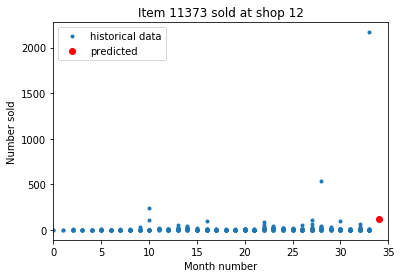

In [5]:
shop = 12
item = 11373 

df = get_df_for_shop_item(shop, item)
pred = pred_from_month33(df)
plot_prediction(shop, item, pred)

In [6]:
test = pd.read_csv('test.csv', nrows=10)

In [7]:
def make_predictions(prediction_function, filename='submission.csv'):
    shops = test.shop_id.values
    items = test.item_id.values
    IDs = test.ID.values
    output = 'ID,item_cnt_month'

    for shop, item, ID in zip(shops, items, IDs):
        df = get_df_for_shop_item(shop, item)
        line = ','.join((str(ID), str(prediction_function(df))))
        output = '\n'.join((output, line))
        
    with open(filename, "w") as f:
        f.write(output)

In [3]:
# start = timer()
# make_predictions(prediction_function=pred_from_month33, filename='submission01_pred_from_month33.csv')
# end = timer()
# print((start-end)/60, 'minutes')

In [9]:
len(test)

214200